## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Training model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping

# Performance metrics calculation support library
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

### Read data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [ ]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [ ]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [ ]:
#  Scaler data
scaler = MinMaxScaler(feature_range = (0, 1))
df_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [ ]:
# Split the data into training, validation and test dataset in a ratio of 7:2:2
train_size = int(len(df_scaled) * 0.7)
val_size = int(len(df_scaled) * 0.2)
test_size = len(df_scaled) - train_size - val_size

train_data = df_scaled[0 : train_size, :]
val_data = df_scaled[train_size : train_size + val_size, :]
test_data = df_scaled[train_size + val_size : len(df_scaled), :]

## Model training and testing

In [ ]:
# Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# Add data for train, validation and test set
time_step = 30

val_last_windowsize = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data_extended, time_step)

In [ ]:
# Make input for DFNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

### Training process

#### Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [ ]:
# Reshape x_train, x_test, x_val to 2 dimensions
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)

In [ ]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(16, ),(32, ),(64, ),(128, ),(256, ), (256, 128), (128, 64), (64, 32),(64, 32, 16), (128, 64, 32), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'adaptive'],
}

In [ ]:
# Create the model
model = MLPRegressor()

In [ ]:
# Find best params (GridSearch Idea)
best_val_mse = float('inf')
best_params = None

for hidden_layer_sizes in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for learning_rate in param_grid['learning_rate']:
            # Create the model
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, learning_rate=learning_rate,
                                 max_iter=10, batch_size=32)

            # Training with EarlyStopping
            es = EarlyStopping(patience=3, verbose=1)
            model.fit(X_train_2d, y_train)

            # Evaluate on validate sets
            y_pred_val=model.predict(X_val_2d)

            # Inverse
            y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

            # Assign y_val to y_val_temp
            y_val_temp = y_val
            y_val_temp = scaler.inverse_transform(y_val_temp.reshape(-1, 1))

            val_mse = mean_squared_error(y_pred_val, y_val_temp)

            # Update best model
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                best_params = {'hidden_layer_sizes': hidden_layer_sizes, 'activation': activation, 'learning_rate': learning_rate}



In [ ]:
# In kết quả
print("Best MSE:", best_val_mse)
print("Best Parameters:", best_params)


Best MSE: 1.965322069281148
Best Parameters: {'hidden_layer_sizes': (256, 128), 'activation': 'relu', 'learning_rate': 'constant'}


### Testing Processing

In [ ]:
y_pred=model.predict(X_test_2d)

### Inverse

In [ ]:
test_data = scaler.inverse_transform(test_data.reshape(-1, 1))

y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

ytest = scaler.inverse_transform(ytest.reshape(-1, 1))


### Evaluate Model

In [ ]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"Testing MAPE: ", test_mape)
print(f"Testing MSE: ", test_mse)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.04762587293029941
Testing MSE:  3.0581232735037442
Testing RMSE:  1.7487490596148276
Testing MSLE:  0.0034215421217288896


## Predicting the next 30 days

### Preparing the prediction data

In [ ]:
x_input = test_data_extended[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()


# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        x_input = x_input.reshape((x_input.shape[0], x_input.shape[1]))

        y_hat = model.predict(x_input)

        temp_input.extend(y_hat.tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat.tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [ ]:
# Print predict next 30 days
print(prediction_next30_days)

[0.1764786845468846, 0.18370418748684036, 0.18534595149305, 0.19109162266842378, 0.19872903539657744, 0.20759152940942183, 0.21164438079410103, 0.22038729676644608, 0.2168806134618922, 0.2161551893838104, 0.215986522294692, 0.22385161356221994, 0.22960337306609857, 0.23665827591361943, 0.24055165264213024, 0.2368353786326401, 0.2350320059855825, 0.24129957793479107, 0.24438675515334318, 0.24803537487821198, 0.2517328833373043, 0.25657711289679697, 0.2571252571513467, 0.2593379994081895, 0.2619295087422447, 0.26394096219391366, 0.2696456759347377, 0.2736404676580085, 0.2775800809812689, 0.28184434682907605]


### Preparing the forecast date index

In [ ]:
# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [ ]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days.reshape(-1,1))

In [ ]:
prediction_next30_days

array([[32.58917646],
       [32.90399163],
       [32.97552329],
       [33.22586219],
       [33.55862427],
       [33.94476314],
       [34.12134588],
       [34.50227474],
       [34.34948855],
       [34.31788182],
       [34.31053299],
       [34.65321503],
       [34.90381919],
       [35.21120132],
       [35.38083575],
       [35.21891768],
       [35.14034474],
       [35.41342285],
       [35.54793117],
       [35.70690153],
       [35.86800198],
       [36.07906507],
       [36.10294771],
       [36.19935689],
       [36.31226896],
       [36.39990799],
       [36.64846237],
       [36.82251545],
       [36.99416441],
       [37.17995847]])

## Visualization

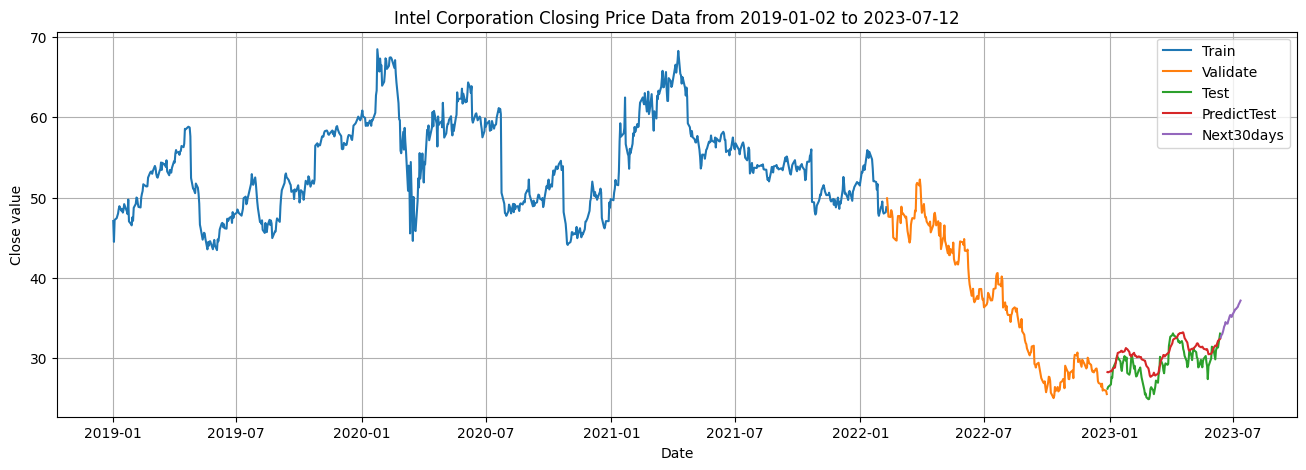

In [ ]:
# Visualization
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], test_data)
plt.plot(df.index[train_size + val_size : ], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.legend(['Train','Validate','Test','PredictTest','Next30days'])

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from 2019-01-02 to 2023-07-12")
plt.xlabel("Date")
plt.ylabel("Close value")
#plt.savefig('../Image/DFNN_712_INTC.png')
plt.show()